# LSTM Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import implicit
from tqdm.notebook import tqdm, trange

from sklearn.model_selection import train_test_split

import sys
sys.path.append("..")

from collections import defaultdict
from importlib import reload

import pickle

from joblib import delayed, Parallel

import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import square, mean, log, dot, flatten, clear_session
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
import df_utils
import mf_utils
import rnn_utils

In [3]:
df = pd.read_csv("cleaned_data_0.2.csv", index_col=[0])

# songs_df = pd.read_csv("songs_DF.csv", index_col=[0])

train_df = pd.read_csv("Train_DF.csv", index_col=[0])
test_df = pd.read_csv("Test_DF.csv", index_col=[0])

# split_train_df = pd.read_csv("Split_Train_DF.csv", index_col=[0])
excl = pickle.load(open("Excluded_Songs_Series.p", "rb"))

# CANNOT use songs_df here as order is different
indx_to_song = mf_utils.indx_mapping(df.spotify_id.unique())

# CHANGE FROM EARLIER NOTEBOOKS - now using train_df and not split_train_df
indx_to_playlist = mf_utils.indx_mapping(train_df.playlist_id.unique())

song_to_indx = mf_utils.indx_mapping(df.spotify_id.unique(), indx_to_item=False)
playlist_to_indx = mf_utils.indx_mapping(train_df.playlist_id.unique(), indx_to_item=False)

/Users/vedantvarshney/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_ratings_matrix = mf_utils.df_to_sparse(train_df, all_songs=df.spotify_id.unique())

# Number of latent factors now 300
wrmf_model = implicit.als.AlternatingLeastSquares(factors=300)

# items_users matrix in this case is the songs_playlist matrix
wrmf_model.fit(train_ratings_matrix)

In [5]:
wrmf_model.user_factors.shape

(10531, 300)

In [6]:
wrmf_model.item_factors.shape

(105152, 300)

In [7]:
playlist_to_indx[6736120]

0

In [255]:
train_df.head()

,source,user_id,track_name,artist_name,playlist_id,tags,playlist_name,spotify_id,album,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,vagalume,sitevagalume,Eraser,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7oolFzHipTMg2nL7shhdz2,÷ (Deluxe),64.0,0.640,0.812,-5.647,0.0834,0.0860,0.000000,0.0509,0.914,86.013
1,vagalume,sitevagalume,Castle On The Hill,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,6PCUP3dWmTjcTtXY02oFdT,÷ (Deluxe),78.0,0.461,0.834,-4.868,0.0989,0.0232,0.000011,0.1400,0.471,135.007
2,vagalume,sitevagalume,Dive,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,51ChrwmUPDJvedPQnIU8Ls,÷ (Deluxe),75.0,0.761,0.386,-6.158,0.0399,0.3550,0.000000,0.0953,0.526,134.943
3,vagalume,sitevagalume,Shape Of You,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7qiZfU4dY1lWllzX7mPBI3,÷ (Deluxe),85.0,0.825,0.652,-3.183,0.0802,0.5810,0.000000,0.0931,0.931,95.977
4,vagalume,sitevagalume,Perfect,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,0tgVpDi06FyKpA1z0VMD4v,÷ (Deluxe),86.0,0.599,0.448,-6.312,0.0232,0.1630,0.000000,0.1060,0.168,95.050


In [254]:
test_df.head()

,source,user_id,track_name,artist_name,playlist_id,tags,playlist_name,spotify_id,album,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
6,vagalume,sitevagalume,Happier,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,2RttW7RAu5nOAfq6YFvApB,÷ (Deluxe),81.0,0.522,0.385,-7.355,0.0288,0.53600,0.000000,0.1350,0.236,89.792
9,vagalume,sitevagalume,How Would You Feel (Paean),Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,6PJ8FF6UR8FZXfEvpHkIVN,÷ (Deluxe),69.0,0.617,0.439,-5.630,0.0269,0.42400,0.000000,0.1270,0.242,139.979
17,vagalume,sitevagalume,Hotline Bling,Drake,6123235,"pop,pop/rock,rock",Fugir do Carnaval Pop 2016,0wwPcA6wtMf6HUMpIRdeP7,Views,77.0,0.891,0.625,-7.861,0.0558,0.00261,0.000176,0.0504,0.548,134.967
31,vagalume,sitevagalume,Freedom,Pitbull,6123235,"pop,pop/rock,rock",Fugir do Carnaval Pop 2016,1StLlgkTm6s0LGRyAap9SP,Climate Change,50.0,0.701,0.931,-4.954,0.1190,0.09490,0.000000,0.1260,0.803,118.034
44,vagalume,sitevagalume,"Bang My Head (Feat. Sia, Fetty Wap (Remix)",David Guetta,6123243,"pop,pop/rock,rock",Fugir Carnaval Eletrônico 2016,440LuUlgdK3j9Uj8Q9L3Yj,Bang My Head (feat. Sia & Fetty Wap),33.0,0.733,0.675,-7.008,0.0647,0.14400,0.186000,0.1000,0.530,122.011


In [9]:
print("Number of unique songs: ", len(df.spotify_id.unique()))

Number of unique songs:  105152


In [10]:
vocab_size = int(40e3)

song_vocab = pd.value_counts(df.spotify_id)[:vocab_size].index.values

In [11]:
song_vocab

array(['4rHZZAmHpZrA3iH5zx8frV', '4v0hWD4N6qefyFrmSGLjTV',
       '2dOTkLZFbpNXrhc24CnTFd', ..., '4hO6t8MOec8hZalXc1LiBL',
       '5BpmwiKR6ns1EtfCQRpNUc', '6xLHcDe6NPWuvpnsiT6ywb'], dtype=object)

In [12]:
song_vocab.shape

(40000,)

In [13]:
songs_series = pd.Series(df.spotify_id.unique())

vocab_indxs = songs_series[songs_series.isin(song_vocab)].index.values

# Reorder songs in vocab. so that they follow the *order* in df.spotify_id.unique()
song_vocab = df.spotify_id.unique()[vocab_indxs]

# New song to index dict. which now corresponds to the smaller vocabulary rather than the entire dataset
song_to_indx_vocab = {song_vocab[i]: i for i in range(len(song_vocab))}

In [14]:
train_playlist_songs_matrix, lengths_series = rnn_utils.create_playlist_song_matrix(train_df, song_to_indx_vocab,
                                                                                    song_vocab=song_vocab)

In [229]:
test_playlist_songs_matrix, test_lengths_series = rnn_utils.create_playlist_song_matrix(test_df, song_to_indx_vocab,
                                                                                        song_vocab=song_vocab)

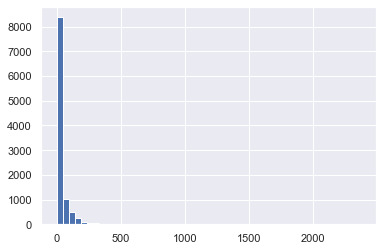

In [16]:
lengths_series.hist(bins=50)

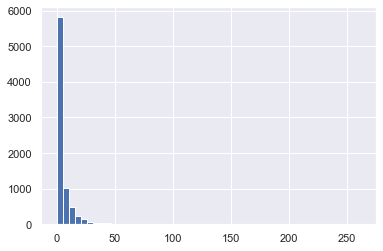

In [253]:
test_lengths_series.hist(bins=50)

Let us check that train_playlist_songs_matrix has the shape (num_playlists, None, num_latent_factors):

In [17]:
print(train_playlist_songs_matrix[2])

[27 29 30 31 32 33 35 36 37 38 39]


In [18]:
wrmf_model.item_factors.shape

(105152, 300)

In [19]:
# latent vectors for each song *IN VOCAB*
item_factors_vocab = wrmf_model.item_factors[vocab_indxs]

In [20]:
item_factors_vocab.shape

(40000, 300)

### TODO
Cannot pass arguments to generators if wrapping in a TF dataset. Check if bug.

Workaround - use global variables

In [207]:
def generate_xy_sample():
    while True:
        for playlist in train_playlist_songs_matrix:
            xsample, ysample = rnn_utils.prepare_sample(playlist, item_factors_vocab, vocab_size)
            yield xsample, ysample

In [312]:
def generate_validation_sample():
    while True:
        for playlist in test_playlist_songs_matrix:
            xsample, ysample = rnn_utils.prepare_sample(playlist, item_factors_vocab, vocab_size)
            yield xsample, ysample

In [313]:
a, b = next(generate_xy_sample())

In [314]:
for x in next(generate_xy_sample()):
    print(x.shape)
    print(x.dtype, "\n")

(6, 300)
float32 

(6, 40000)
int32 



In [315]:
a

array([[ 0.00602189, -0.00175472,  0.00586928, ..., -0.00643963,
        -0.00358253,  0.00539631],
       [ 0.01440937,  0.00866992,  0.02106015, ..., -0.01529669,
        -0.01496681,  0.00370339],
       [ 0.02567204,  0.06783669,  0.08630717, ..., -0.02815304,
         0.03548595, -0.0366329 ],
       [-0.00236878,  0.01952095,  0.01547904, ..., -0.01277475,
        -0.02320292, -0.00567305],
       [-0.03153174,  0.22949632,  0.06107102, ..., -0.18887359,
        -0.1346917 ,  0.05337438],
       [ 0.01267892,  0.03493347,  0.00290621, ...,  0.00689641,
        -0.01097857,  0.00892946]], dtype=float32)

In [316]:
b

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [317]:
type(x for x in b)

generator

In [318]:
assert np.array((x == 1).any() for x in b).all()

In [319]:
num_latent_factors = 300

# IMPORTANT NOTE - set to 320 if using GPU (Google Colab.)
# num_latent_factors = 320

In [348]:
train_dataset = tf.data.Dataset.from_generator(generate_xy_sample,
                                              output_types=(tf.float32, tf.int32),
                                              output_shapes=(tf.TensorShape([None, num_latent_factors]), tf.TensorShape([None, vocab_size]))
                                              )

In [349]:
for x in next(train_dataset.batch(1).as_numpy_iterator()):
    print(x.shape)
    print(x.dtype, "\n")

(1, 6, 300)
float32 

(1, 6, 40000)
int32 



In [350]:
test_dataset = tf.data.Dataset.from_generator(generate_validation_sample,
                                              output_types=(tf.float32, tf.int32),
                                              output_shapes=(tf.TensorShape([None, num_latent_factors]), tf.TensorShape([None, vocab_size]))
                                              )

In [351]:
for x in next(test_dataset.as_numpy_iterator()):
    print(x.shape)
    print(x.dtype, "\n")

(1, 300)
float32 

(1, 40000)
int32 



In [324]:
item_factors_T = tf.convert_to_tensor(item_factors_vocab.T, dtype=tf.float32)
item_factors_T.shape

TensorShape([300, 40000])

In [325]:
BATCH_SIZE = 1

item_factors_T_batch = tf.tile(tf.expand_dims(item_factors_T, axis=0), multiples=[BATCH_SIZE, 1, 1])

In [326]:
print(item_factors_T_batch.shape)
print(item_factors_T_batch.dtype)

(1, 300, 40000)
<dtype: 'float32'>


In [327]:
item_factors_T_batch.shape

TensorShape([1, 300, 40000])

In [328]:
tf.shape(item_factors_T_batch)[0]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [329]:
epsilon = 1e-5

In [330]:
def custom_loss(y_true, y_pred):
    """
    Essentially converts a classification problem to a regression problem.
    """
#  y_true - shape (batch_size, playlist_length, multihot ie vocab_size ie 40k)
#  y_pred - shape (batch_size, playlist_length, 300)

    loss = 0

#     Cast to a boolean mask. Consider changing during preprocessing.
    y_true = tf.cast(y_true, tf.bool)
    
#     Contains all the necessary dot products
    composite = tf.matmul(y_pred, item_factors_T_batch)
        
# TODO - improve such that only have to run through mask once.
    correct = tf.boolean_mask(composite, y_true)
    incorrect = tf.boolean_mask(composite, ~y_true)
    
    tf.print(tf.math.sigmoid(correct))
    
    loss -= tf.math.reduce_sum(log(tf.math.sigmoid(correct) + epsilon))
    loss -= tf.math.reduce_sum(log(1-tf.math.sigmoid(incorrect) + epsilon))
    
    return loss
        

In [331]:
# TEST - custom loss function

a, b = next(train_dataset.batch(1).as_numpy_iterator())

print(a.shape)
print(a.dtype)

print(b.shape)
print(b.dtype)

print(custom_loss(b, a))

(1, 6, 300)
float32
(1, 6, 40000)
int32
[0.504186392 0.502449691 0.503188372 ... 0.54395479 0.501901627 0.500137568]
tf.Tensor(167652.88, shape=(), dtype=float32)


## Creating Model

In [154]:
print(num_latent_factors)
print(vocab_size)

300
40000


In [352]:
clear_session()

In [353]:
LSTM_L1_UNITS = 320
LSTM_L2_UNITS = 50
LEARNING_RATE = 1e-3

model = Sequential()

model.add(LSTM(units=LSTM_L1_UNITS,
              return_sequences=True,
              input_shape=(None, num_latent_factors)))

model.add(LSTM(units=LSTM_L2_UNITS,
              return_sequences=True,
              input_shape=(None, LSTM_L1_UNITS)))

model.add(Dense(units=num_latent_factors, activation="tanh"))

optimiser = RMSprop(lr=LEARNING_RATE)

model.compile(loss=custom_loss, optimizer=optimiser)

In [354]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 320)         794880    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 50)          74200     
_________________________________________________________________
dense (Dense)                (None, None, 300)         15300     
Total params: 884,380
Trainable params: 884,380
Non-trainable params: 0
_________________________________________________________________


In [355]:
train_playlist_songs_matrix.shape[0]

9519

In [356]:
approx_dof = train_playlist_songs_matrix.shape[0] * 10 * 300

In [357]:
approx_dof

28557000

## TODO
We cannot select a batch size greater than 1 without fixing the length of each input (i.e. padding and truncating).

In [358]:
callbacks = [EarlyStopping(monitor="val_loss", patience=10, verbose=1)]

In [359]:
# INTERNAL NOTE - Run in Google Collab. to make use of a GPU

history = model.fit(train_dataset.shuffle(100).batch(1),
                    epochs=6,
                    steps_per_epoch=train_playlist_songs_matrix.shape[0])
#                     steps_per_epoch=train_playlist_songs_matrix.shape[0])
                    validation_data=validation_data,
#          callbacks=callbacks)

IndentationError: unexpected indent (<ipython-input-359-7269fe004d02>, line 7)

In [360]:
# INTERNAL NOTE - Run in Google Collab. to make use of a GPU

history = model.fit(train_dataset.shuffle(100).batch(1),
                    epochs=1,
                    steps_per_epoch=2,
                    validation_data=test_dataset.batch(1),
                    validation_steps=test_playlist_songs_matrix.shape[0])


[0.497461915 0.500525773 0.494164288 ... 0.507944047 0.502427578 0.50246942]
2/2 [==============================] - ETA: 0s - loss: 870326.4375[0.49857837]
[0.498258442]
[0.497214824]
[0.492429525 0.495726407 0.493713677 0.490935624 0.491673291 0.490528822]
[0.499000728 0.497854441 0.496058971 ... 0.492638588 0.487194538 0.486373782]
[0.495994091 0.492875814 0.489837795]
[0.481671065 0.495135516 0.494792879]
[0.50648421 0.487996191 0.501080334 ... 0.507350445 0.498809427 0.506438375]
[0.493488491 0.495870888 0.494489789]
[0.497537971 0.491375893 0.490044981]
[0.486638069]
[0.501044214 0.501259089 0.501302421 0.50147289 0.501518726 0.501752734]
[0.495830685 0.496807814 0.496048331]
[0.496821195 0.488787919 0.488215089]
[0.499688387 0.494808793 0.497340292 0.501267612 0.495886922 0.495231]
[0.494897574]
[0.495916605]
[0.499304026 0.497802734 0.498723835 ... 0.497092277 0.499465287 0.499344528]
[0.497764289 0.49763751 0.497005284]
[0.485199034 0.495884985 0.50130713 ... 0.492234558 0.4920

[0.496598482 0.498899758 0.498818278]
[0.496829778 0.494448155 0.499424934 0.496448636 0.499520838 0.494421273]
[0.491594911 0.499995023 0.490633577]
[0.4946329 0.497852474 0.49714911]
[0.484555215 0.495524108 0.472323179 ... 0.440994859 0.490206242 0.490122378]
[0.497358024 0.49746421 0.497058094]
[0.491954237 0.499317884 0.49728334 ... 0.490118712 0.500086427 0.500187278]
[0.492564321 0.48135072 0.500986636 ... 0.513140619 0.463026106 0.462411463]
[0.499054939 0.503059566 0.502402961 0.503207088 0.502467155 0.503290236]
[0.496388882]
[0.495889515 0.497928888 0.497422427 0.49821192 0.497578323 0.497563869]
[0.498354435 0.498452 0.490269661 ... 0.499283 0.495192677 0.498652369]
[0.496087074]
[0.49639675]
[0.493853211]
[0.499677658]
[0.497739524 0.497212887 0.4972094 ... 0.496920198 0.497351408 0.497493207]
[0.500668645 0.494288564 0.495579511 ... 0.501623571 0.496065736 0.501433194]
[0.496934503 0.49736169 0.49586913 ... 0.480349422 0.501251 0.500726521]
[0.492903799 0.484792113 0.4799

[0.478577912 0.496129483 0.497576 ... 0.501016557 0.48871395 0.488225788]
[0.498304278]
[0.489301056]
[0.479062825 0.496915311 0.499316603 ... 0.498609364 0.499043554 0.498968363]
[0.497830033 0.498339474 0.496568531 0.497879386 0.496275216 0.497985303]
[0.498613447 0.500111639 0.49665311 ... 0.497870028 0.495580673 0.495369405]
[0.497073412]
[0.49640435 0.491646796 0.496759623]
[0.493494868 0.495209396 0.49533245 ... 0.498762429 0.491648167 0.491596252]
[0.495283872 0.503719151 0.492784262 ... 0.488504231 0.480014473 0.482927382]
[0.495886594 0.495392889 0.497689039 ... 0.495229125 0.498967379 0.498900145]
[0.494412452 0.495255888 0.494332492]
[0.495233238 0.494882494 0.494724214]
[0.498694271]
[0.48174575 0.490718246 0.492777109 ... 0.49582538 0.495797426 0.495564908]
[0.50077647 0.50410682 0.493936181 ... 0.494772971 0.475257903 0.491650403]
[0.497605473 0.498289287 0.495681971 ... 0.503484726 0.523228288 0.523280859]
[0.498856783 0.493068397 0.499299377 ... 0.493676662 0.493836015 

[0.496498436 0.500023901 0.495957285]
[0.496061116 0.494091928 0.492622 ... 0.464063853 0.44157204 0.440790355]
[0.467979729 0.479265302 0.489672124 ... 0.40349 0.484903425 0.486055]
[0.496781826]
[0.49782005 0.494385451 0.499197096 0.493608296 0.498886555 0.498686582]
[0.496527612 0.489228636 0.495236 ... 0.498631388 0.488586605 0.488630861]
[0.497941881 0.484194726 0.498045385 ... 0.4962309 0.498131126 0.495711744]
[0.495774925 0.498685479 0.497121483 ... 0.496997029 0.496683598 0.496516436]
[0.49489814]
[0.495026141 0.494490743 0.498616576 0.494600117 0.498232 0.494143784]
[0.494169861 0.48317039 0.48040536]
[0.498373955 0.49046427 0.493422 ... 0.48979485 0.491668254 0.490346909]
[0.492183894 0.493046522 0.498072267 ... 0.480931908 0.485311806 0.482456505]
[0.484572977 0.491514355 0.489285469 ... 0.456096262 0.49288097 0.490391493]
[0.501764417 0.491024524 0.498850226 0.504906952 0.500512421 0.501853883]
[0.49706158 0.496674806 0.496956795]
[0.497143179 0.496174693 0.496002138]
[0.4

[0.489360422 0.487074137 0.492855787 ... 0.481247395 0.497716874 0.480863959]
[0.499126673 0.492328912 0.491250306 ... 0.479045689 0.46762225 0.478128225]
[0.492650241]
[0.50797379 0.493982255 0.493829191 ... 0.491938233 0.492206782 0.490726858]
[0.499766678 0.498150349 0.497958302]
[0.492081881 0.49115321 0.49378705 ... 0.488226682 0.494024515 0.4882828]
[0.492509276]
[0.493212849 0.499986172 0.500662863 0.492210209 0.500774086 0.491288722]
[0.487856835 0.492648512 0.492193103]
[0.497663975 0.499650985 0.490938306 ... 0.486980438 0.500843585 0.500866592]
[0.455577672]
[0.48113662 0.489161938 0.497299135 ... 0.490583748 0.494519621 0.491056293]
[0.471227944 0.500490844 0.468597919]
[0.498497]
[0.497518808 0.497861236 0.498828739 ... 0.496050686 0.495674521 0.495132059]
[0.499150127 0.498886794 0.498650283]
[0.498468578 0.498152792 0.498578697]
[0.499160528 0.497689575 0.497496873]
[0.499522895]
[0.499370188]
[0.499186 0.500404716 0.500407875 0.500449181 0.500458121 0.500542581]
[0.4969

[0.466288179 0.488899469 0.48742947 ... 0.431724697 0.498203814 0.428126812]
[0.500055075 0.492154688 0.499064058 ... 0.497092098 0.500028551 0.500091255]
[0.491889507 0.498164624 0.495607585 ... 0.493986458 0.494861871 0.493027598]
[0.496886522]
[0.49225539 0.500561655 0.485268801 ... 0.484208137 0.499188721 0.49885729]
[0.492830038 0.488831043 0.48710236 ... 0.478288293 0.49658674 0.497370541]
[0.499145448 0.499503 0.499430865]
[0.498155504 0.49952811 0.499518901]
[0.481265038 0.497404516 0.494986236 ... 0.499042541 0.498706311 0.498642951]
[0.495935589 0.495888859 0.496455938 ... 0.497022748 0.506359398 0.497125089]
[0.480444044 0.498172045 0.498764634 ... 0.474554062 0.497442961 0.470996499]
[0.484183371 0.496987909 0.498624 ... 0.491060525 0.488489687 0.488277674]
[0.49765709 0.495348066 0.494113326 ... 0.502782345 0.492493421 0.492028385]
[0.496679723 0.494295239 0.493941963 ... 0.50210011 0.494133145 0.493726879]
[0.495542347 0.492036641 0.494407892 ... 0.484524518 0.395221412 0

[0.491135 0.478408515 0.488074273 ... 0.494701177 0.499798596 0.499795765]
[0.483085334 0.495758951 0.492118925 ... 0.480801135 0.487048149 0.487000912]
[0.488901407 0.494556487 0.496140718 ... 0.509734809 0.490902185 0.486909]
[0.487042785 0.492089 0.496614218 ... 0.495595485 0.499863058 0.495282561]
[0.49983421 0.496354759 0.497412086 ... 0.502210557 0.496366501 0.495826334]
[0.498592228 0.499602854 0.472067297 ... 0.493425727 0.497013927 0.496836036]
[0.495690674 0.492908508 0.501966357 ... 0.495739818 0.496167332 0.495549]
[0.491745859 0.493618727 0.494992316 ... 0.490829438 0.493761778 0.493442208]
[0.500860512 0.481528491 0.498621106 ... 0.50981462 0.512645662 0.513149738]
[0.509725273 0.491649598 0.498898238 ... 0.491132945 0.499694139 0.490443349]
[0.491660833 0.496149331 0.495963931 ... 0.476775408 0.491048664 0.490742952]
[0.478744149 0.497593403 0.492211729 ... 0.494271576 0.49649471 0.494252592]
[0.486626595 0.492791981 0.494080126 ... 0.490986824 0.492343098 0.491895139]
[

[0.489216834 0.491025954 0.496194601 ... 0.5199278 0.51649189 0.516878366]
[0.493738949 0.500517726 0.498704791 ... 0.49786514 0.494631261 0.497837514]
[0.495831221 0.499008238 0.498361588 0.495472461 0.498341173 0.4983854]
[0.497036397 0.498067081 0.497868687]
[0.468127191 0.494898885 0.49219808 ... 0.500850558 0.499700576 0.499958]
[0.487404436 0.497698218 0.495893508 ... 0.494394273 0.461525202 0.462334812]
[0.498946548]
[0.494137138 0.496626198 0.498648971 0.493431807 0.49638921 0.492830455]
[0.493282109 0.494712979 0.498867214 ... 0.498472333 0.5 0.5]
[0.498573869 0.491803765 0.493607819 ... 0.491247773 0.49286297 0.490627825]
[0.49190864 0.489305526 0.494344741 ... 0.489910752 0.496054351 0.489349216]
[0.490532815]
[0.498023272 0.492327213 0.499433428 ... 0.497591168 0.490423232 0.497577071]
[0.485096 0.499914676 0.500067711 ... 0.4767088 0.501021802 0.501104176]
[0.492812097 0.490297198 0.498521179 0.491861671 0.489034146 0.488982022]
[0.498022735 0.497858018 0.497864395 0.49758

[0.499303758 0.489907473 0.481386095 ... 0.497009814 0.489860862 0.48892647]
[0.487617016 0.498607457 0.497177362 ... 0.504097819 0.496969253 0.497087896]
[0.498777658 0.490528971 0.498311162]
[0.49647671 0.494963944 0.4972018 0.493924171 0.497171581 0.496763438]
[0.492220581 0.484921426 0.50032407 ... 0.530362189 0.492561758 0.488863796]
[0.489388168 0.494737864 0.495447308 ... 0.494302 0.49663049 0.493564904]
[0.48781994 0.490945518 0.489869565]
[0.496427596]
[0.486894429 0.497558475 0.494053721 ... 0.498949796 0.494294018 0.498759866]
[0.494980723 0.497852683 0.481825441 ... 0.499308437 0.502020717 0.499416023]
[0.487884283 0.496028215 0.485660166]
[0.492267758 0.503427744 0.49378705 ... 0.498128265 0.493642479 0.496923178]
[0.498690307 0.498990625 0.498672783]
[0.490956664 0.494856149 0.498773932 0.494595468 0.498885483 0.49433744]
[0.498093098 0.492023915 0.498078316 ... 0.495859206 0.49616462 0.495635509]
[0.479821652 0.499239743 0.479064435]
[0.486256659 0.497232765 0.495858192 

KeyboardInterrupt: 

In [337]:
next(test_dataset.batch(1).as_numpy_iterator())[0].shape

(1, 1, 300)

In [338]:
next(test_dataset.batch(1).as_numpy_iterator())[1].shape

(1, 1, 40000)